## Data Processing
The first thing to do after understanding the problem statement is to observe the overall shape of the data. Let's begin by first looking at the distribution of labels. 

We will not be using the is_tma for now as there are no thumbnail images for those. 

In [76]:
import pandas as pd

train = pd.read_csv("./data/train.csv")

# remove all is_tma, as there are no thumbnail images that aren't that 
train = train[~train["is_tma"]]

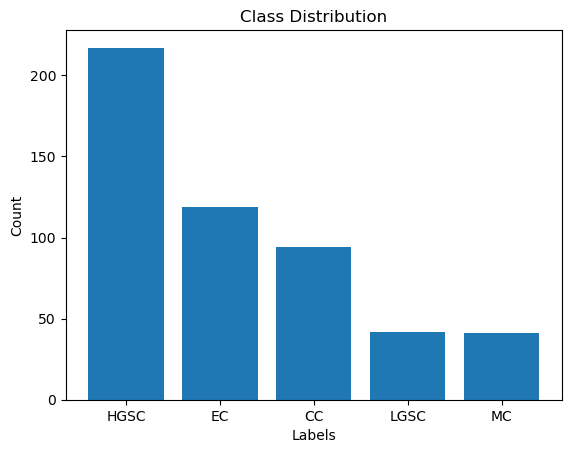

In [77]:
# Plot out the label distribution
import matplotlib.pyplot as plt

label_counts = train["label"].value_counts()
labels, counts = label_counts.index, label_counts.values

plt.bar(labels, counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show();

Clearly, there is a imbalance of the different classes, with HGSC being the most common type. 

Let's also load the data up.

In [78]:
import numpy as np
import torch

np.random.seed(1234)
torch.manual_seed(1234);

In [79]:
import cv2
from sklearn.model_selection import train_test_split
np.random.RandomState()

img_ids = train["image_id"]
labels = train["label"]

X = []
y = []

for img_id, label in zip(img_ids, labels):
    img_path = "./small_data/" + str(img_id) + "_thumbnail.png" # change if using differnt data
    img = cv2.imread(img_path)

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

Let's first encode the labels (which are currently strings) somehow, so let's also do that.

In [80]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

Create the training and validation split.

In [81]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y, random_state=1234) # stratified

Now let's find the appropriate weight for each class

In [82]:
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)

# Create a WeightedRandomSampler to use in model
weights = torch.DoubleTensor([class_weights[label] for label in y_encoded])
sampler = WeightedRandomSampler(torch.DoubleTensor(class_weights), len(y_encoded), replacement=True)

Now we're ready for our simple model. First, let's define a very basic efficient-net model to quickly train and evalute the effectiveness of the data processing.

In [83]:
import torch.nn as nn
import torch.optim as optim
import timm

model_0_name = "efficientnet_b0"

num_classes = 5
model_0 = timm.create_model(model_0_name, pretrained=False, num_classes=num_classes)

# loss func + optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

Let's begin by training the first model, ```model_0```, with no image processing and evalute its results.

In [84]:
from torch.utils.data import DataLoader, TensorDataset

# bootstrap up
num_bootstrap_samples = 512 # to see runtimes 64, took roughly 12s per epoch, total 5 min


# initialize lists to store bootstrapped data
random_indexes= np.random.randint(0, len(X_tr), size=num_bootstrap_samples)
X_b_tr = X_tr[random_indexes]
y_b_tr = y_encoded[random_indexes]

train_dataset = TensorDataset(torch.tensor(X_b_tr.astype(np.float32) / 255), torch.tensor(y_b_tr))
val_dataset = TensorDataset(torch.tensor(X_val.astype(np.float32) / 255), torch.tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# store validation accuracies for later
val_accuracies = []

# training loop
num_epochs = 5
for epoch in range(num_epochs):
    model_0.train()
    running_loss = 0.0

    for batch_imgs, batch_labels in train_loader:
        optimizer.zero_grad()
        batch_imgs = batch_imgs.permute(0, 3, 1, 2)  # permute dimensions for PyTorch (B, H, W, C) -> (B, C, H, W)
        outputs = model_0(batch_imgs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# validation loop
model_0.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.permute(0, 3, 1, 2) # permute dimensions
        outputs = model_0(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# calc val acc
val_acc = 100 * (correct / total)
val_accuracies.append(val_acc)

print(f"Validation Accuracy: {correct}/{total}, {val_acc:.4f}%")

print("Training Complete.")

Epoch 1/5, Loss: 0.5527949051157681
Epoch 2/5, Loss: 0.0008998790719274172
Epoch 3/5, Loss: 2.717398628620712
Epoch 4/5, Loss: 0.5818653579828542
Epoch 5/5, Loss: 1.1416643186226685
Validation Accuracy: 18.4466%
Training Complete.


Now let's create model that grayscales the images.

In [85]:
model_gray_name = "efficientnet_b0"

num_classes = 5
model_gray = timm.create_model(model_gray_name, pretrained=False, num_classes=num_classes, in_chans=1)

# loss func + optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
optimizer = optim.Adam(model_gray.parameters(), lr=0.001)

In [86]:
# Initialize lists to store bootstrapped data
random_indexes= np.random.randint(0, len(X_tr), size=num_bootstrap_samples)
X_b_tr = X_tr[random_indexes]
y_b_tr = y_encoded[random_indexes]

# convert bootstrapped data to grayscale
X_b_tr = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_b_tr]
X_b_tr = np.array(X_b_tr)  # Shape should be (num_samples, height, width)

# convert validation data to grayscale as well
X_val_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_val]
X_val_gray = np.array(X_val_gray)  # Shape should be (num_samples, height, width)

X_b_tr = X_b_tr[:, np.newaxis, :, :]
X_val_gray = X_val_gray[:, np.newaxis, :, :]

train_dataset = TensorDataset(torch.tensor(X_b_tr.astype(np.float32) / 255), torch.tensor(y_b_tr))
val_dataset = TensorDataset(torch.tensor(X_val_gray.astype(np.float32) / 255), torch.tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model_gray.train()
    running_loss = 0.0

    for batch_imgs, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model_gray(batch_imgs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Validation loop
model_gray.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model_gray(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate validation accuracy
val_acc = 100 * (correct / total)
val_accuracies.append(val_acc)

print(f"Validation Accuracy: {correct}/{total}, {val_acc:.4f}%")

print("Training Complete.")


Epoch 1/5, Loss: 0.2792864124524332
Epoch 2/5, Loss: 0.005419871419623151
Epoch 3/5, Loss: 0.00017728224173746096
Epoch 4/5, Loss: 0.0032510059083618362
Epoch 5/5, Loss: 7.210852251576478e-05
Validation Accuracy: 24.2718%
Training Complete.


It seems as though turning the image to grayscale does not affect the overall results that much. Let's try randomly applying transformations on the training data and seeing what may happen. 

In [87]:
model_transform_name = "efficientnet_b0"

num_classes = 5
model_transform = timm.create_model(model_transform_name, pretrained=False, num_classes=num_classes, in_chans=1)

# loss func + optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
optimizer = optim.Adam(model_transform.parameters(), lr=0.001)

In [88]:
from PIL import Image
from torchvision import transforms

# Initialize lists to store bootstrapped data
random_indexes= np.random.randint(0, len(X_tr), size=num_bootstrap_samples)
X_b_tr = X_tr[random_indexes]
y_b_tr = y_encoded[random_indexes]

# convert bootstrapped data to grayscale
X_b_tr = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_b_tr]

# apply transofmations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip vertically
    transforms.RandomRotation(360),      # Randomly rotate anywhere
    transforms.ToTensor(),              # Convert to tensor
])

transformed_data = []
for img in X_b_tr:
    # Convert the image from OpenCV format to PIL format
    pil_img = Image.fromarray(img)
    
    # Apply the transformations
    transformed_img = data_transforms(pil_img)
    
    # Convert the transformed image back to NumPy format
    transformed_img = np.array(transformed_img)
    
    transformed_data.append(transformed_img)

X_b_tr = np.array(transformed_data)

X_b_tr = np.array(X_b_tr)  # Shape should be (num_samples, height, width)

# convert validation data to grayscale as well
X_val_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_val]
X_val_gray = np.array(X_val_gray)  # Shape should be (num_samples, height, width)

# X_b_tr = X_b_tr[:, np.newaxis, :, :]
# print(X_b_tr.shape)
X_val_gray = X_val_gray[:, np.newaxis, :, :]

train_dataset = TensorDataset(torch.tensor(X_b_tr.astype(np.float32) / 255), torch.tensor(y_b_tr))
val_dataset = TensorDataset(torch.tensor(X_val_gray.astype(np.float32) / 255), torch.tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model_transform.train()
    running_loss = 0.0

    for batch_imgs, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model_transform(batch_imgs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Validation loop
model_transform.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model_transform(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate validation accuracy
val_acc = 100 * (correct / total)
val_accuracies.append(val_acc)

print(f"Validation Accuracy: {correct}/{total}, {val_acc:.4f}%")

print("Training Complete.")


Epoch 1/5, Loss: 0.23441259404463016
Epoch 2/5, Loss: 0.22807243878587846
Epoch 3/5, Loss: 0.032316117558843706
Epoch 4/5, Loss: 0.115117625146267
Epoch 5/5, Loss: 0.0040274684033146085
Validation Accuracy: 42.7184%
Training Complete.


In [89]:
val_accuracies

[18.446601941747574, 24.271844660194176, 42.71844660194174]

graph of the different models and their validation accuracies

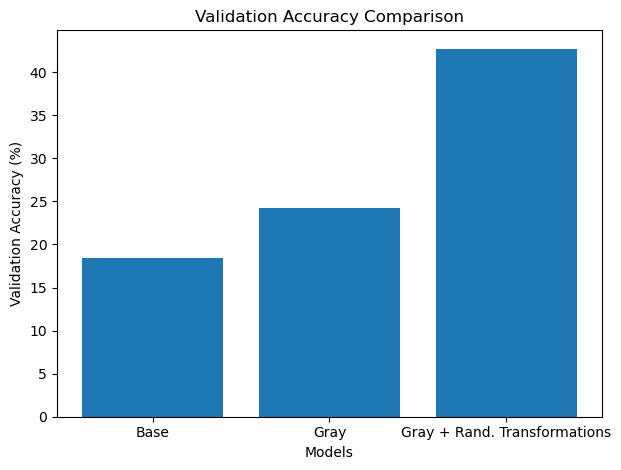

In [95]:
models = ["Base", "Gray", "Gray + Rand. Transformations"]

plt.bar(models, val_accuracies)

plt.xlabel("Models")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison")

plt.tight_layout()